         Date     RegionName   AreaCode  AveragePrice  Index  IndexSA  \
0  01/01/2004  Aberdeenshire  S12000034         84638   41.1      NaN   
1  01/02/2004  Aberdeenshire  S12000034         84623   41.1      NaN   
2  01/03/2004  Aberdeenshire  S12000034         86536   42.1      NaN   
3  01/04/2004  Aberdeenshire  S12000034         87373   42.5      NaN   
4  01/05/2004  Aberdeenshire  S12000034         89493   43.5      NaN   

   1m%Change  12m%Change  AveragePriceSA  SalesVolume  ...  NewPrice  \
0        NaN         NaN             NaN        388.0  ...  112843.0   
1        0.0         NaN             NaN        326.0  ...  113061.0   
2        2.3         NaN             NaN        453.0  ...  115218.0   
3        1.0         NaN             NaN        571.0  ...  115247.0   
4        2.4         NaN             NaN        502.0  ...  117377.0   

   NewIndex  New1m%Change  New12m%Change  NewSalesVolume  OldPrice  OldIndex  \
0      40.7           NaN            NaN        

/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jcl/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


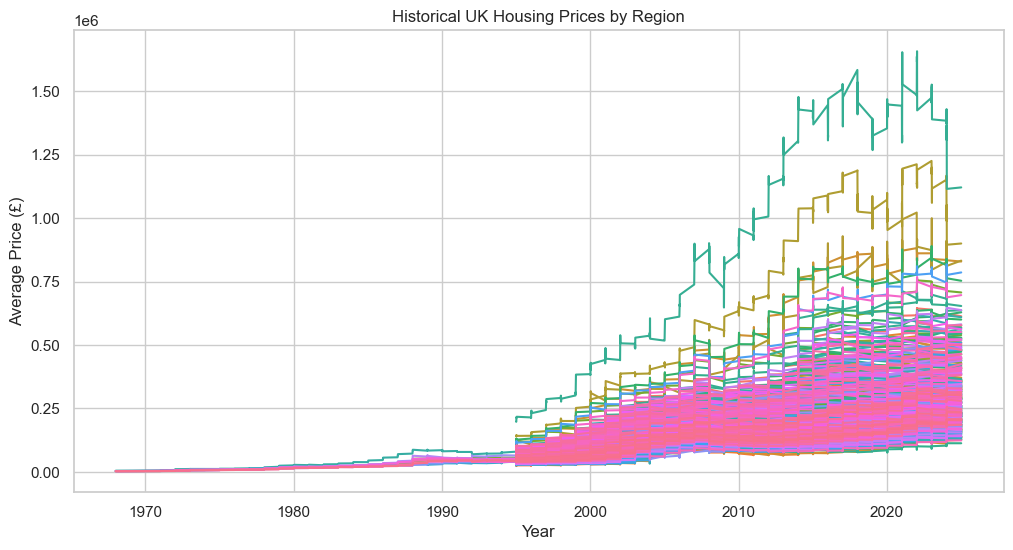

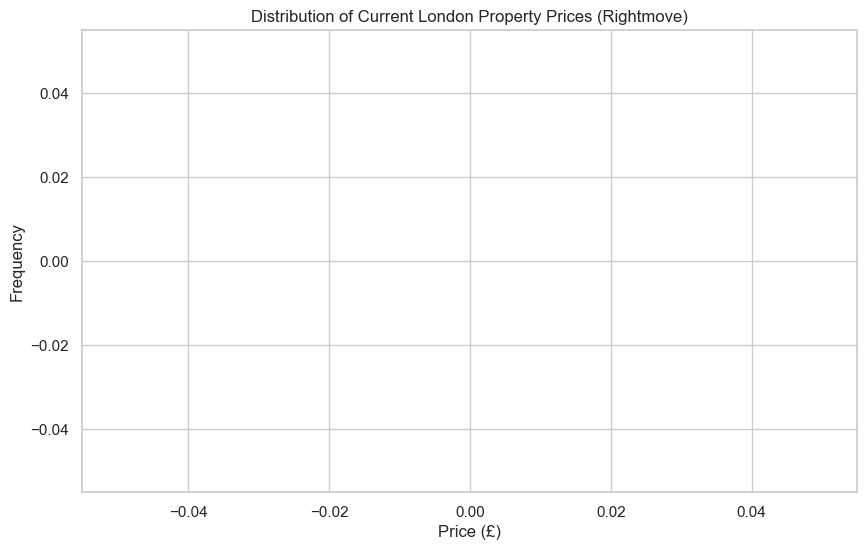

Regression Mean Squared Error: 16178982110.28


In [10]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

hpi = pd.read_csv('/Users/jcl/uk-housing-analysis/data/UK-HPI-full-file-2025-01.csv')
affordability = pd.read_excel('/Users/jcl/uk-housing-analysis/data/aff1ratioofhousepricetoworkplacebasedearnings2024.xlsx')

print(hpi.head())
print(affordability.head())

hpi['Date'] = pd.to_datetime(hpi['Date'], errors='coerce')
hpi = hpi.dropna(subset=['Date', 'AveragePrice'])
hpi = hpi[['Date', 'RegionName', 'AveragePrice', 'SalesVolume']]

affordability.columns = affordability.columns.str.strip().str.replace(" ", "_")

print(hpi.info())
print(affordability.info())

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

url = "https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E87490&radius=0.0"

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

prices = [price.text.replace('£', '').replace(',', '').strip()
          for price in soup.find_all('div', class_='propertyCard-priceValue')]

current_prices = pd.DataFrame(prices, columns=['Price'])
current_prices['Price'] = pd.to_numeric(current_prices['Price'], errors='coerce').dropna()

print(current_prices.head())

plt.figure(figsize=(12, 6))
sns.lineplot(data=hpi, x='Date', y='AveragePrice', hue='RegionName', legend=False)
plt.title('Historical UK Housing Prices by Region')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(current_prices['Price'], bins=30, kde=True)
plt.title('Distribution of Current London Property Prices (Rightmove)')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.show()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = hpi[['SalesVolume']].fillna(hpi['SalesVolume'].mean())
y = hpi['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f'Regression Mean Squared Error: {mse:.2f}')

## 